In [390]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [391]:
# Load shreds in a random order
indices = [6, 2, 4, 0, 8, 7, 5, 1, 3]

shreds = []

for i in indices:
    shred = cv.imread(f"shredded\shred{i}.png")
    shred = cv.cvtColor(shred, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(shred, 0, 255, cv.THRESH_BINARY)
    shreds.append(thresh)

shreds = np.array(shreds)
print(shreds.shape)

(9, 1110, 100)


In [392]:
# First find the 2 ends of the doc
ordered = {}
idx1 = 0
idx2 = 0
tf1 = 0
tf2 = 0

for i in range(shreds.shape[0]):
    shred = shreds[i]
    count1 = 0
    count2 = 0
    for j in range(shred.shape[0]):
        if shred[j][0] == 0 or shred[j][1] == 0 or shred[j][2] == 0 or shred[j][3] == 0 or shred[j][4] == 0:
        # if shred[j][0] == 255 or shred[j][1] == 255 or shred[j][2] == 255 or shred[j][3] == 255 or shred[j][4] == 255:
            count1 += 1
        if shred[j][shred.shape[1]-1] == 0 or shred[j][shred.shape[1]-2] == 0 or shred[j][shred.shape[1]-3] == 0 or shred[j][shred.shape[1]-4] == 0 or shred[j][shred.shape[1]-5] == 0:
        # if shred[j][shred.shape[1]-1] == 255 or shred[j][shred.shape[1]-2] == 255 or shred[j][shred.shape[1]-3] == 255 or shred[j][shred.shape[1]-4] == 255 or shred[j][shred.shape[1]-5] == 255:
            count2 += 1
        
        if count1 == 20 and count2 == 20:
            break
    
    if count1 == 0:
        ordered[0] = shred
        idx1 = i
        tf1 = 1
    if count2 == 0:
        ordered[shreds.shape[0]-1] = shred
        idx2 = i
        tf2= 1
    if tf1 == 1 and tf2 == 1:
        break

In [393]:
# Removing shreds that have been added to "ordered"
n_shreds = []
for i in range(shreds.shape[0]):
    if i == idx1 or i == idx2:
        continue
    n_shreds.append(shreds[i])

n_shreds = np.array(n_shreds)
print(n_shreds.shape, idx1, idx2)

(7, 1110, 100) 3 4


In [394]:
# Probabilistic Scoring
for i in range(shreds.shape[0]-2):
    o_shred = ordered[i]
    s_score = []
    # print("i ", i)

    for j in range(n_shreds.shape[0]):
        sum = 0
        shred = n_shreds[j]
        # print("j ", j)

        for k in range(2, shred.shape[0]-2):
            cost = 0.7 * (o_shred[k][o_shred.shape[1]-1] - shred[k][0]) + 0.1 * (o_shred[k-1][o_shred.shape[1]-1] - shred[k-1][0]) + 0.1 * (o_shred[k+1][o_shred.shape[1]-1] - shred[k+1][0]) + 0.05 * (o_shred[k-2][o_shred.shape[1]-1] - shred[k-2][0]) + 0.05 * (o_shred[k+2][o_shred.shape[1]-1] - shred[k+2][0])
            # sum += abs(cost)
            if abs(cost) > 0:
                sum += 1
            # if i == 0 and j == 5:
            #     print("k ", cost)

        s_score.append(sum)

    # print("before max")
    m_idx = s_score.index(min(s_score))
    # print("after max")
    ordered[i+1] = n_shreds[m_idx]

    temp_shreds = []
    for i in range(n_shreds.shape[0]):
        if i == m_idx:
            continue
        temp_shreds.append(n_shreds[i])
    
    n_shreds = np.array(temp_shreds)


C:\Users\prana\AppData\Local\Temp\ipykernel_33904\873440237.py:13: RuntimeWarning: overflow encountered in scalar subtract
  cost = 0.7 * (o_shred[k][o_shred.shape[1]-1] - shred[k][0]) + 0.1 * (o_shred[k-1][o_shred.shape[1]-1] - shred[k-1][0]) + 0.1 * (o_shred[k+1][o_shred.shape[1]-1] - shred[k+1][0]) + 0.05 * (o_shred[k-2][o_shred.shape[1]-1] - shred[k-2][0]) + 0.05 * (o_shred[k+2][o_shred.shape[1]-1] - shred[k+2][0])


True

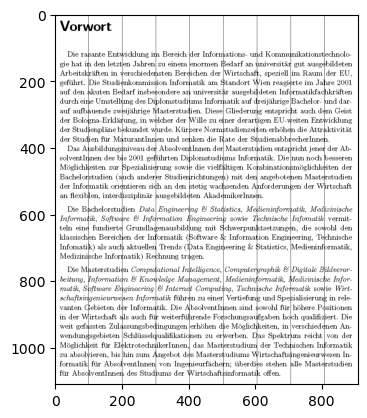

In [395]:
new_image = ordered[0]
line = np.full((new_image.shape[0], 1), 0, dtype='uint8')
# line = np.full((1110, 1), 255, dtype='uint8')
for i in range(1, len(ordered)):
    new_image = np.hstack((new_image, line))
    new_image = np.hstack((new_image, ordered[i]))

# print(new_image[20])
# _, new_image = cv.threshold(new_image, 0, 255, cv.THRESH_BINARY_INV)
plt.imshow(new_image, cmap='gray')
cv.imwrite("output.png", new_image)